In [7]:
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from skimage.io import imread, imshow
from skimage.transform import resize, rotate
from numpy import random
import numpy as np
from keras.preprocessing.image import image_utils
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import os

# Please consider below pre-defined values and modify according to available training dataset 
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
NUM_IMAGES = 1000
NUM_DATASET_IMAGES = 790 

seed = 42
np.random.seed = seed

In [8]:
#print(tf.__version__)    #2.9.2
#print(keras.__version__) #2.9.0

In [9]:
# Initializing dataset with proper formats 
data_X = np.zeros((NUM_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
data_Y = np.zeros((NUM_IMAGES, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

In [10]:

# path to place where training images and corresponding masks are stored
# Please modify it for your training purpose if needed
DATA_PATH_X = '/content/drive/MyDrive/seep_detection/seep_detection/train_images_256'
DATA_PATH_Y = '/content/drive/MyDrive/seep_detection/seep_detection/train_masks_256'

# Fetching and Preprocessing of Input image data into proper format
# Preprocessing part depends on images available for training/Test
for root, dir, files in os.walk(DATA_PATH_X):
  #print(root)
  #print(dir)
  for index, file in enumerate(files):
    img_path = DATA_PATH_X + '/' + file
    img = image_utils.load_img(img_path, color_mode = "grayscale")
    xmg = image_utils.img_to_array(img)
    # resize in case input image exceeds pre-defined image size for model training
    xmg = resize(xmg, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
    data_X[index] = xmg/65535.0  # normalize

    mask_path = DATA_PATH_Y + '/' + file
    mask = image_utils.load_img(mask_path, color_mode = "grayscale")
    mask = np.squeeze(image_utils.img_to_array(mask))
    # In case of  detecting seep(type not matter), making all seep pixel label to be same
    mask = np.array([[1 if i>0 else 0 for i in sublist] for sublist in mask]) 
    # resize in case input image exceeds pre-defined image size for model training
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    data_Y[index] = mask 

 

In [11]:
# Randomly Augmenting dataset images to increase size and diversity
# Currently, it has toal of 790 images. Need to add extra 210(70 + 70 + 70) images using 
# image rotation of randomly selected image from available dataset

# Image Augmentation function
def imageAugmentationUsingRotation(startIndex, endIndex, angle):
  for index in range(NUM_DATASET_IMAGES + startIndex, NUM_DATASET_IMAGES + endIndex):
    random_idx = random.randint(0, NUM_DATASET_IMAGES)

    image_rot = rotate(data_X[random_idx], angle, preserve_range=True).astype(np.float32)
    data_X[index] = image_rot
    
    mask_rot = rotate(data_Y[random_idx], angle, preserve_range=True).astype(np.uint8)
    data_Y[index] = mask_rot
  

# 90 degree rotation 
imageAugmentationUsingRotation(0, 70, angle=90)

# 180 degree rotation 
imageAugmentationUsingRotation(70, 140, angle=180)

# 270 degree rotation 
imageAugmentationUsingRotation(140, 210, angle=270)


In [12]:
#Shuffling and splitting total data(1000 image-mask pair) into Train and Test data with split of (90%, 10%)
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size=0.1, random_state=seed)


Text(0.5, 1.0, 'SAR-Image Mask(Seep)')

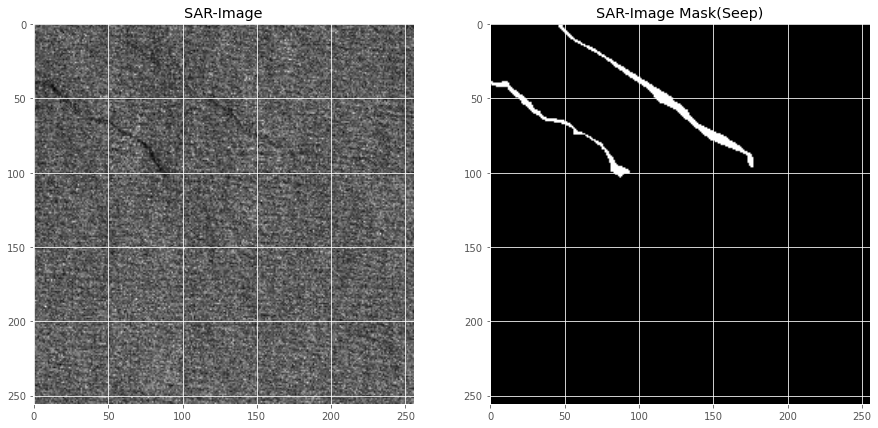

In [14]:
# Visualize any random SAR image along with the mask
idx = random.randint(0, len(train_X))
has_seep = train_Y[idx].max() > 0   # seep indicator
#print(train_Y[idx])
figure, (axis1, axis2) = plt.subplots(1, 2, figsize = (15, 10))
axis1.imshow(train_X[idx, ..., 0], cmap = 'gray', interpolation = 'bilinear')
axis1.set_title('SAR-Image')

axis2.imshow(train_Y[idx].squeeze(), cmap = 'gray', interpolation = 'bilinear')
axis2.set_title('SAR-Image Mask(Seep)')

In [15]:
# Understanding data distribution for each labels[Non-seep, Seep] in training dataset 
# which will affect the model training and evaluation metrics
# when ratio of class weights for each labels are very high => Highly Imbalanced data
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_Y), y = np.squeeze(train_Y).ravel())
print(class_weights)

[ 0.50692932 36.57859551]


In [16]:
#Building Input layer
inputs = keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='SAR_Image')

In [17]:
# Using U-NET model for training on given SAR image dataset to predict Oil Seeps
# This model consist of Encoder-Decoder channel which includes:
#  1. Convolutional Layer with MaxPooling for Down Sampling operation to learn features
#     for prediction of Seeps in the image
#  2. Later using ConvolutionTranspose for Up Sampling and further Uses concatenation 
#     with Encoder Convolution layer to preserve Locatization information of pixels    



#Encoding (also called Contraction) Part
def encodingConvolutionalLayer(num_filters, input, batchNorm = True) :
  conv = keras.layers.Conv2D(filters=num_filters, kernel_size = (3,3), kernel_initializer = 'he_normal', padding='same')(input)
  if batchNorm:
    conv = keras.layers.BatchNormalization()(conv)
  conv = keras.layers.Activation('relu')(conv)
  conv = keras.layers.Conv2D(num_filters, (3,3), activation='relu', kernel_initializer = 'he_normal', padding='same')(conv)
  if batchNorm:
    conv = keras.layers.BatchNormalization()(conv)
  conv = keras.layers.Activation('relu')(conv)
  return conv

#layer 1
conv1 = encodingConvolutionalLayer(16, inputs, True)
pool1 = keras.layers.MaxPool2D((2,2))(conv1)
pool1 = keras.layers.Dropout(0.1)(pool1)

#layer 2
conv2 = encodingConvolutionalLayer(32, pool1, True)
pool2 = keras.layers.MaxPool2D((2,2))(conv2)
pool2 = keras.layers.Dropout(0.1)(pool2)

#layer 3
conv3 = encodingConvolutionalLayer(64, pool2, True)
pool3 = keras.layers.MaxPool2D((2,2))(conv3)
pool3 = keras.layers.Dropout(0.2)(pool3)

#layer 4
conv4 = encodingConvolutionalLayer(128, pool3, True)
pool4 = keras.layers.MaxPool2D((2,2))(conv4)
pool4 = keras.layers.Dropout(0.3)(pool4)

#layer 5 (bottom)
conv5 = encodingConvolutionalLayer(256, pool4, True)

#Decoding (also called Expanding) Part
def decodingConvolutionalTransposeLayer(num_filters, dropout, encodingLayer, input) :
  upLayer = keras.layers.Conv2DTranspose(num_filters, (3,3), strides=(2,2), padding='same')(input)
  upLayer = keras.layers.concatenate([upLayer, encodingLayer])  #putting pixel localization information while constructing back
  upLayer = keras.layers.Dropout(dropout)(upLayer)
  conv = encodingConvolutionalLayer(num_filters, upLayer, True)
  return conv

#layer 6
decodingLayer1 = decodingConvolutionalTransposeLayer(128, 0.3, conv4, conv5)

#layer 7
decodingLayer2 = decodingConvolutionalTransposeLayer(64, 0.2, conv3, decodingLayer1)

#layer 8
decodingLayer3 = decodingConvolutionalTransposeLayer(32, 0.1, conv2, decodingLayer2)

#layer 9
decodingLayer4 = decodingConvolutionalTransposeLayer(16, 0.1, conv1, decodingLayer3)

# output layer 
# for binary classification, number of output = 1, activation = sigmoid
outputs = keras.layers.Conv2D(1, (1,1), activation='sigmoid')(decodingLayer4) 


In [18]:
# Hybrid of Tversky and BCE loss function
# Tversky helps in handling imbalanced factor in dataset by providing constants
# to penalise False Positive and False Negatives in the loss function
def Tversky_BCE_Loss(y_true, y_pred, alpha=0.5, beta=0.5, smooth=1e-6):
        
        #To get better recall or Sensivity (increase beta value),
        alpha = 0.3
        beta  = 0.7

        y_pred = tf.cast(y_pred, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        smooth = tf.cast(smooth, tf.float32)

        #flatten label and prediction tensors
        y_pred = K.flatten(y_pred)
        y_true = K.flatten(y_true)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((y_pred * y_true))
        FP = K.sum(((1-y_true) * y_pred))
        FN = K.sum((y_true * (1-y_pred)))
       
        Tversky_loss = 1 - (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        # Binary Loss entropy for stablization of loss function
        BCE_loss =  keras.losses.binary_crossentropy(y_true, y_pred)
        Tversky_BCE_loss = Tversky_loss + BCE_loss
        
        return Tversky_BCE_loss

In [19]:
# defining model
# Used Intersection over Union (IoU) as metrics because it is pixel-based criterion
# it takes intersection of predicted and true mask  divided by union of them.
# This metrics gives more importance to how accuractly the seep part is predicted 
# rather than non-seep part which helps in measuring tight boundaries as compared to true mask
model = keras.Model(inputs = [inputs], outputs = [outputs])
adam = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=adam, loss=[Tversky_BCE_Loss], metrics=[keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5), 'accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 SAR_Image (InputLayer)         [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['SAR_Image[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [20]:
#Model training Monitoring functions
checkPointer = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/seep_detection/m_model_seep_detection.h5', verbose=1, save_best_only=True, save_weights_only=True)
calbacks = [
    keras.callbacks.EarlyStopping(patience=10, verbose=1),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/seep_detection/logs')]


In [21]:
# Training the model with callbacks and class_weights
results = model.fit(train_X, train_Y, batch_size=16, epochs=50, callbacks=calbacks, validation_data=(test_X, test_Y))

Epoch 1/50
57/57 [==============================] - 25s 222ms/step - loss: 1.4284 - binary_io_u: 0.0214 - accuracy: 0.8528 - val_loss: 1.4029 - val_binary_io_u: 9.7040e-04 - val_accuracy: 0.9835 - lr: 5.0000e-04
Epoch 2/50
57/57 [==============================] - 11s 186ms/step - loss: 1.2010 - binary_io_u: 0.0789 - accuracy: 0.9670 - val_loss: 1.1750 - val_binary_io_u: 0.0000e+00 - val_accuracy: 0.9868 - lr: 5.0000e-04
Epoch 3/50
57/57 [==============================] - 11s 189ms/step - loss: 1.0884 - binary_io_u: 0.1628 - accuracy: 0.9670 - val_loss: 1.0961 - val_binary_io_u: 3.1463e-05 - val_accuracy: 0.9855 - lr: 5.0000e-04
Epoch 4/50
57/57 [==============================] - 11s 191ms/step - loss: 1.0067 - binary_io_u: 0.2079 - accuracy: 0.9721 - val_loss: 1.0943 - val_binary_io_u: 3.6177e-04 - val_accuracy: 0.9836 - lr: 5.0000e-04
Epoch 5/50
57/57 [==============================] - 11s 193ms/step - loss: 0.9394 - binary_io_u: 0.2440 - accuracy: 0.9754 - val_loss: 1.0750 - val_bina

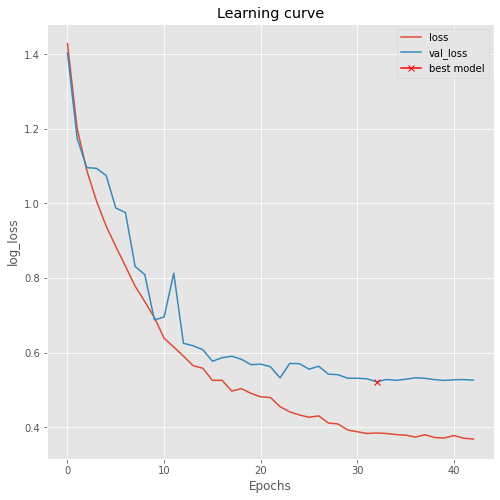

In [22]:
# Plotting Loss per epochs for model learning
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [23]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(test_X, test_Y, verbose=1)

4/4 [==============================] - 2s 72ms/step - loss: 0.5365 - binary_io_u: 0.3619 - accuracy: 0.9866


[0.5364981293678284, 0.3618517816066742, 0.986572265625]

In [24]:
# Predict on train and test
preds_train = model.predict(train_X, verbose=1)
preds_test = model.predict(test_X, verbose=1)

4/4 [==============================] - 0s 84ms/step


In [25]:
# Do Threshold predictions as the predicted values are propbability values between [0, 1]
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [26]:
# Plot samples along with predicted one
def plot_sample(X, y, preds, binary_preds, idx=None):
    
    if idx is None:
        idx = random.randint(0, len(X))

    has_mask = y[idx].max() > 0
    print(idx)
    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    # Actual SAR image
    ax[0].imshow(X[idx, ..., 0], cmap='gray')
    ax[0].set_title('SAR-Image')

    # Actual SAR image Mask
    ax[1].imshow(y[idx].squeeze())
    ax[1].set_title('SAR-Image Mask (Seep)')
    if has_mask:
        ax[1].contour(y[idx].squeeze(), colors='r', levels=[0.5])

    # Predicted seep area with overlapped true seep boundary
    ax[2].imshow(preds[idx].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[idx].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Seep Predicted')
    
    # Predicted (Binary form) seep area with overlapped predicted seep boundary
    ax[3].imshow(binary_preds[idx].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(binary_preds[idx].squeeze(), colors='r', levels=[0.5])
    ax[3].set_title('Seep Predicted binary');

460


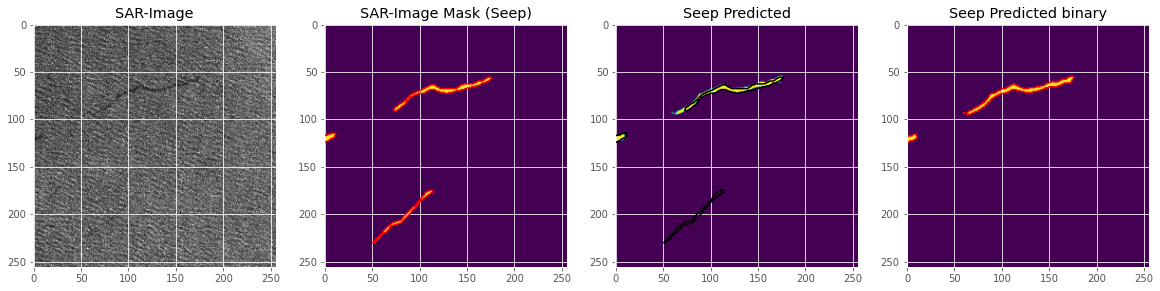

In [44]:
plot_sample(train_X, train_Y, preds_train, preds_train_t)

47


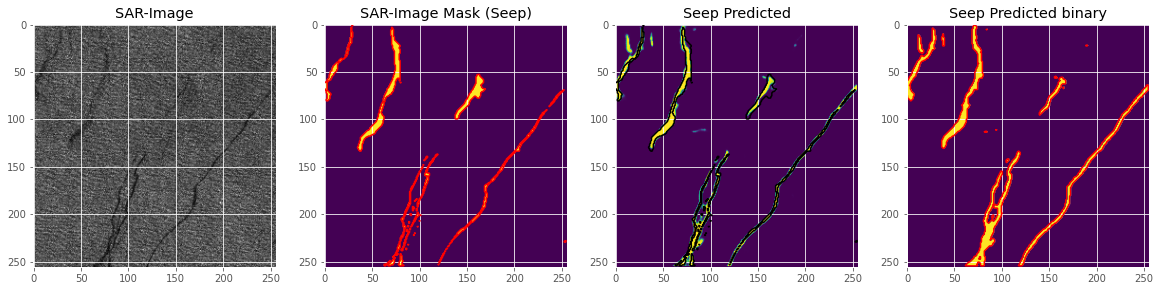

In [33]:
plot_sample(test_X, test_Y, preds_test, preds_test_t)